# The annotated encoder-decoer with attention

Based on [this blog](https://bastings.github.io/annotated_encoder_decoder/)

Consider an input sequence $X=(x_1, ..., x_M)$ and a target sequence $Y=(y_1, ..., y_N)$. We will model the probability $p(Y|X)$ directly with a neural network: an encoder-decoder.

<img src="../figures/enc.jpg">

## Encoder

The encoder reads in the source sentence (bottom of above figure) and produces a sequence of hidden states $\mathbf{h_1,...,h_M}$ for each input word. These hidden states should capture the meaning of a word **in its context** given the sentence. Use a Bi-GRU as the encoder.

We first embed the source words: each source word's embedding is denoted as a vector $\mathbf{x}_i$. Using an embedding allows us to exploit the fact that certain words are semantically similar, and should therefore be processed in a similar way by having close embedding vectors.

We obtain the hidden states $\mathbf{h_1,...,h_M}$ from the recursive formula
$$\mathbf{h}_j = GRU(\mathbf{x}_j, \mathbf{h}_{j-1})$$
for a forward GRU. A backward GRU reads from right-to-left instead of left-to-right. We therefore obtain two hidden state vectors for each word. Concatenating the two hidden states together allows us to obtain a local context for each word.

## Decoder

The decoder is also a GRU with hidden state $\mathbf{s}_i$. It follows a similar formula to the encoder, but takes one extra input $\mathbf{c}_i$ (shown in yellow) called the **context**
$$\mathbf{s}_i = f(\mathbf{s}_{i-1}, \mathbf{y}_{i-1}, \mathbf{c}_{i})$$
where $\mathbf{y}_{i-1}$ is the embedding for the previously generated target word.

At each time step, an **attention mechanism** dynamically selects the part of the source sentence that is most relevant for predicting the current target word. It does so by comparing the last decoder state  with each source hidden state (**TODO: FILL IN MATHS**)

After computing the decoder state $\mathbf{s}_i$, a non-linear function $g$ (softmax) gives us the probability of the target word $y_i$ for this time step:
$$p(y_i|y_{<i},x_1^M) = g(\mathbf{s}_{i-1}, \mathbf{y}_{i-1}, \mathbf{c}_{i})$$

## Attention

At every time step, the decoder has access to **all** source word representations $\mathbf{h}_1, ..., \mathbf{h}_M$. An attention mechanism allows the model to focus on the currently most relevant part of the source sentence. 

The attention mechanism takes as input the current state of the decoder $\mathbf{s}_i$, and $(\mathbf{h}_1, ..., \mathbf{h}_M)$. We apply a multilayer perceptron to both the current decoder state $\mathbf{s}_i$ (the **query**) and each encoder state $\mathbf{h}_j$ (the **key**), and then project this to a scalar to get the **attention energy** $e_{ij}$. 

We then normalize the attention energies using a softmax
$$\alpha_{ij} = \mathrm{softmax}(\mathbf{e}_i)[j]$$
The context vector at time step $i$ is then a weighted sum of the encoder hidden states (the **values**)
$$\mathbf{c}_i = \sum_j \alpha_{ij} \mathbf{h}_j$$

<img src="../figures/bahdanau.jpg">

## The model

In [1]:
import sys
sys.path.append('../src')

In [2]:
from seq.enc_dec_attn.synth import train_copy_task, plot_perplexity

C:\Users\jarya\miniconda3\envs\sequence-models\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0
Epoch step: 50 Loss: (19.88688087463379, 11352.967029992573)
Epoch step: 100 Loss: (18.266408920288086, 11688.563963453824)
Evaluation perplexity: 7.207996

Example #1
Src :  3 6 2 8 3 1 9 8 4
Trg :  3 6 2 8 3 1 9 8 4
Pred:  3 3 3 3 3 3 3 8 3

Example #2
Src :  7 4 4 4 4 4 8 5 1
Trg :  7 4 4 4 4 4 8 5 1
Pred:  4 4 4 4 4 4 4 4 4

Epoch 1
Epoch step: 50 Loss: (15.506646156311035, 11764.93068392767)
Epoch step: 100 Loss: (13.004790306091309, 11697.061828207403)
Evaluation perplexity: 3.788299

Example #1
Src :  3 6 2 8 3 1 9 8 4
Trg :  3 6 2 8 3 1 9 8 4
Pred:  3 6 3 8 3 8 4 9 8

Example #2
Src :  7 4 4 4 4 4 8 5 1
Trg :  7 4 4 4 4 4 8 5 1
Pred:  4 4 4 7 4 4 4 4 7

Epoch 2
Epoch step: 50 Loss: (8.92684555053711, 11532.002971690466)
Epoch step: 100 Loss: (5.992276668548584, 12429.789935690147)
Evaluation perplexity: 1.877379

Example #1
Src :  3 6 2 8 3 1 9 8 4
Trg :  3 6 2 8 3 1 9 8 4
Pred:  3 6 3 8 2 8 9 4 1

Example #2
Src :  7 4 4 4 4 4 8 5 1
Trg :  7 4 4 4 4 4 8 5 1
Pred:  4 7 

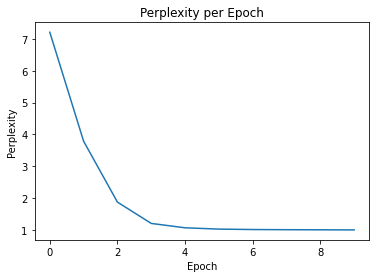

In [3]:
dev_perplexities = train_copy_task()
plot_perplexity(dev_perplexities)